In [ ]:
### imports, install
import sys
!{sys.executable} -m pip install  matplotlib pandas numpy pandasql openpyxl nx pydot graphviz openpyxl
!{sys.executable} -m pip install ipyleaflet pandasql
!{sys.executable} -m pip install xlrd pyexcel
!{sys.executable} -m pip install networkx

In [2]:
### imports
import pandas as pd
import pandasql as pdsql

import math
import json

from ipyleaflet import Map, Marker, Polyline, AntPath


In [3]:
### function to read excel into dataframe
def getDataFrame(pFileName, pColNameVector, pDictColValue):
    ds=open(pFileName, "rb")
    df=pd.read_excel(pFileName, index_col=False, names=pColNameVector, dtype = pDictColValue,  engine='openpyxl')
    ds.close()
    print(df)
    return df

In [4]:
### read dataframe
## dataset 1 - routes
fileName= './DataSets/ticketToRide.xlsx'
namesDs1=[ "city1", "distance",  "color", "tracks", "city2"]
dictType = {"city1":"str", "distance":"int", "color":"str", "tracks":"int", "city2":"str"}
df1=getDataFrame(fileName, namesDs1, dictType)

          city1  distance   color  tracks       city2
0     Vancouver         1    gray       2     Seattle
1     Vancouver         1    gray       2     Seattle
2     Vancouver         3    gray       1     Calgary
3       Seattle         1    gray       2    Portland
4       Seattle         4    gray       1     Calgary
..          ...       ...     ...     ...         ...
95  New Orleans         4  orange       2     Atlanta
96  New Orleans         6     red       1       Miami
97      Atlanta         2    gray       1  Charleston
98      Atlanta         5   black       1       Miami
99   Charleston         4    pink       1       Miami

[100 rows x 5 columns]


In [5]:
#@dataset2: latitude & longitude
fileName= './DataSets/ticketToRide-coords.xlsx'
namesDs1=[ "city1", "latitude",  "longitude"]
dictType = {"city1":"str", "latitude":"float", "longitude":"float"}
df2=getDataFrame(fileName, namesDs1, dictType)

             city1  latitude  longitude
0        Vancouver     49.28    -123.12
1          Seattle     47.60    -122.33
2          Calgary     51.04    -114.07
3         Portland     45.50    -122.67
4           Helena     46.59    -112.04
5         Winnipeg     49.90     -97.14
6    San Francisco     37.77    -122.42
7   Salt Lake City     40.76    -111.89
8           Duluth     46.78     -92.00
9            Omaha     41.25     -95.93
10          Denver     39.74    -104.99
11  Sault St Marie     46.51     -84.33
12     Los Angeles     34.05    -118.24
13         Toronto     46.65     -79.38
14         Chicago     41.88     -87.63
15     Kansas City     39.10     -94.58
16         Phoenix     33.44    -112.07
17        Santa Fe     35.68    -105.94
18   Oklahoma City     35.46     -97.51
19        Montreal     45.50     -73.56
20         El Paso     31.76    -106.48
21      Pittsburgh     40.44     -80.00
22        St Louis     38.62     -90.20
23          Dallas     32.77     -96.80


In [6]:
## merging dataframes
sqlJoin=""" select 
df1.city1 as orig
, df1.city2 as dest
, df1.distance
, df1.color
, loc1.latitude as orig_lat
, loc1.longitude as orig_lon
, loc2.latitude as dest_lat
, loc2.longitude as dest_lon

from 

df1  
inner join 
df2 loc1 
on df1.city1 = loc1.city1 

inner join
df2 loc2
on df1.city2=loc2.city1


"""
dfCitiesLocation = pdsql.sqldf(sqlJoin, locals())
print (dfCitiesLocation)

           orig        dest  distance   color  orig_lat  orig_lon  dest_lat  \
0     Vancouver     Seattle         1    gray     49.28   -123.12     47.60   
1     Vancouver     Seattle         1    gray     49.28   -123.12     47.60   
2     Vancouver     Calgary         3    gray     49.28   -123.12     51.04   
3       Seattle    Portland         1    gray     47.60   -122.33     45.50   
4       Seattle     Calgary         4    gray     47.60   -122.33     51.04   
..          ...         ...       ...     ...       ...       ...       ...   
93  New Orleans     Atlanta         4  orange     29.95    -90.07     33.75   
94  New Orleans       Miami         6     red     29.95    -90.07     25.76   
95      Atlanta  Charleston         2    gray     33.75    -84.39     32.77   
96      Atlanta       Miami         5   black     33.75    -84.39     25.76   
97   Charleston       Miami         4    pink     32.77    -79.93     25.76   

    dest_lon  
0    -122.33  
1    -122.33  
2    -

In [8]:
dfCitiesLocation.to_csv('./DataSets/ticketToRide_edges.csv',sep=';', header=True, quotechar='"')

In [7]:
#https://ipyleaflet.readthedocs.io/en/latest/api_reference/marker.html
class Location:
    def __init__(self, pLat=36.3, pLong=137.97):
        self.latitude =pLat
        self.longitude=pLong

In [9]:
## New York
m = Map(center=(40, -74), zoom=6)

In [131]:
## Display the map
m

Map(center=[40, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [10]:

## print all routes
ant_paths = []
for route in dfCitiesLocation.itertuples():
    
    ## origin
    orig_name  = getattr(route, "orig")
    orig_lon=getattr(route, "orig_lon")
    orig_lat = getattr(route, "orig_lat")
    center_orig = (orig_lat, orig_lon )
    
    mark_orig = Marker(location=center_orig
                       , title =orig_name
                       , draggable=False
                      )
    m.add_layer(mark_orig)
    
    
    ## destination
    dest_name= getattr(route, "dest")
    dest_lon=getattr(route,"dest_lon")
    dest_lat = getattr(route, "dest_lat")
    center_dest = (dest_lat, dest_lon)
    
    mark_dest = Marker(location=center_dest
                       , title=dest_name
                       , draggable=False
                      )
    m.add_layer(mark_dest)
   
    
    
    routeColor = getattr(route, "color")
    distance = getattr(route,"distance")
    
    ### ant path
    #ant_paths.append(AntPath(locations=[[orig_lat, orig_lon ], [dest_lat, dest_lon]]
    #                         , use="polyline"
    #                        , weigth = 0.5 +distance
    #                        , color = routeColor))
    #m += ant_paths[-1]
    
    
    ### polyline
    line = Polyline(
        locations=[[orig_lat, orig_lon ], [dest_lat, dest_lon]]
        , weight = distance
        , color = routeColor
    )
    m.add_layer(line)
    
    
    print("orig: ", orig_name, " - dest: ", dest_name, " dist: ", distance, " color : ", routeColor)
    
m

orig:  Vancouver  - dest:  Seattle  dist:  1  color :  gray
orig:  Vancouver  - dest:  Seattle  dist:  1  color :  gray
orig:  Vancouver  - dest:  Calgary  dist:  3  color :  gray
orig:  Seattle  - dest:  Portland  dist:  1  color :  gray
orig:  Seattle  - dest:  Calgary  dist:  4  color :  gray
orig:  Seattle  - dest:  Helena  dist:  6  color :  yellow
orig:  Calgary  - dest:  Helena  dist:  4  color :  gray
orig:  Calgary  - dest:  Winnipeg  dist:  6  color :  white
orig:  Portland  - dest:  San Francisco  dist:  5  color :  green
orig:  Portland  - dest:  San Francisco  dist:  5  color :  pink
orig:  Portland  - dest:  Salt Lake City  dist:  6  color :  blue
orig:  Helena  - dest:  Salt Lake City  dist:  3  color :  pink
orig:  Helena  - dest:  Winnipeg  dist:  4  color :  blue
orig:  Helena  - dest:  Duluth  dist:  6  color :  orange
orig:  Helena  - dest:  Omaha  dist:  5  color :  red
orig:  Helena  - dest:  Denver  dist:  4  color :  green
orig:  Winnipeg  - dest:  Sault St Mari

Map(center=[40, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [11]:
%matplotlib notebook
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt

%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

In [12]:
import networkx as nx

In [13]:
multiGraph= nx.MultiGraph()
singleGraph = nx.Graph()

In [14]:

for edge in df1.itertuples():
    print(getattr(edge, "city1"), getattr(edge, "city2"))
    multiGraph.add_edge(getattr(edge, "city1"), getattr(edge, "city2")
                        , weight = getattr(edge, "distance")
                        , label = getattr(edge, "distance")
                        , penwidth = 1.2*getattr(edge, "distance")
                        , color = getattr(edge, "color"))
    
    singleGraph.add_edge(getattr(edge, "city1"), getattr(edge, "city2")
                        , weight = getattr(edge, "distance")
                        , label = getattr(edge, "distance")
                        , penwidth = 1.2*getattr(edge, "distance")
                        , color = getattr(edge, "color"))



Vancouver Seattle
Vancouver Seattle
Vancouver Calgary
Seattle Portland
Seattle Calgary
Seattle Helena
Calgary Helena
Calgary Winnipeg
Portland San Francisco
Portland San Francisco
Portland Salt Lake City
Helena Salt Lake City
Helena Winnipeg
Helena Duluth
Helena Omaha
Helena Denver
Winnipeg Sault St Marie
Winnipeg Duluth
San Francisco Salt Lake City
San Francisco Salt Lake City
San Francisco Los Angeles
San Francisco Los Angeles
Salt Lake City Las Vegas
Salt Lake City Denver
Salt Lake City Denver
Duluth Sault St Marie
Duluth Toronto
Duluth Chicago
Duluth Omaha
Duluth Omaha
Omaha Denver
Omaha Kansas City
Omaha Kansas City
Omaha Chicago
Denver Kansas City
Denver Kansas City
Denver Phoenix
Denver Santa Fe
Denver Oklahoma City
Sault St Marie Montreal
Sault St Marie Toronto
Los Angeles Las Vegas
Los Angeles El Paso
Los Angeles Phoenix
Toronto Montreal
Toronto Pittsburgh
Toronto Chicago
Chicago Pittsburgh
Chicago Pittsburgh
Chicago St Louis
Chicago St Louis
Kansas City St Louis
Kansas City S

In [72]:
multiGraph.number_of_edges()

100

In [107]:
singleGraph.number_of_edges()

78

In [64]:
multiGraph.number_of_nodes()

36

In [108]:
singleGraph.number_of_nodes()

36

In [80]:
nx.density(multiGraph)

0.15873015873015872

In [109]:
nx.density(singleGraph)

0.12380952380952381

In [81]:
nx.is_weighted(multiGraph)

True

In [82]:
nx.algorithms.number_of_isolates(multiGraph)

0

In [16]:
## sorted: https://careerkarma.com/blog/python-sort-a-dictionary-by-value/
## sorted by closeness descending
dict=nx.algorithms.closeness_centrality(multiGraph)
sorted(dict.items(), key=lambda x:x[1], reverse=True)

[('Denver', 0.3977272727272727),
 ('Omaha', 0.38461538461538464),
 ('Kansas City', 0.38461538461538464),
 ('Chicago', 0.3804347826086957),
 ('St Louis', 0.3804347826086957),
 ('Helena', 0.3763440860215054),
 ('Oklahoma City', 0.3723404255319149),
 ('Duluth', 0.3684210526315789),
 ('Little Rock', 0.3645833333333333),
 ('Pittsburgh', 0.35353535353535354),
 ('Toronto', 0.3431372549019608),
 ('Nashville', 0.33980582524271846),
 ('Salt Lake City', 0.3333333333333333),
 ('Dallas', 0.330188679245283),
 ('Winnipeg', 0.32710280373831774),
 ('Santa Fe', 0.32710280373831774),
 ('Phoenix', 0.32407407407407407),
 ('El Paso', 0.3153153153153153),
 ('Sault St Marie', 0.3125),
 ('Raleigh', 0.30434782608695654),
 ('New Orleans', 0.30434782608695654),
 ('Calgary', 0.2966101694915254),
 ('Seattle', 0.2916666666666667),
 ('Los Angeles', 0.28688524590163933),
 ('Atlanta', 0.28688524590163933),
 ('Houston', 0.2845528455284553),
 ('San Francisco', 0.28225806451612906),
 ('New York', 0.28225806451612906),
 ('

In [17]:
## degree centrality
dict=nx.algorithms.degree_centrality(multiGraph)
sorted(dict.items(), key=lambda x:x[1], reverse=True)

[('Denver', 0.2857142857142857),
 ('Pittsburgh', 0.2571428571428571),
 ('Kansas City', 0.22857142857142856),
 ('Oklahoma City', 0.22857142857142856),
 ('Helena', 0.19999999999999998),
 ('Salt Lake City', 0.19999999999999998),
 ('Duluth', 0.19999999999999998),
 ('Omaha', 0.19999999999999998),
 ('Chicago', 0.19999999999999998),
 ('St Louis', 0.19999999999999998),
 ('New York', 0.19999999999999998),
 ('Raleigh', 0.19999999999999998),
 ('Atlanta', 0.19999999999999998),
 ('San Francisco', 0.17142857142857143),
 ('El Paso', 0.17142857142857143),
 ('Dallas', 0.17142857142857143),
 ('Seattle', 0.14285714285714285),
 ('Los Angeles', 0.14285714285714285),
 ('Toronto', 0.14285714285714285),
 ('Phoenix', 0.14285714285714285),
 ('Montreal', 0.14285714285714285),
 ('Little Rock', 0.14285714285714285),
 ('Washington', 0.14285714285714285),
 ('Nashville', 0.14285714285714285),
 ('New Orleans', 0.14285714285714285),
 ('Calgary', 0.11428571428571428),
 ('Portland', 0.11428571428571428),
 ('Winnipeg', 0.

In [18]:
dict=nx.algorithms.betweenness_centrality(multiGraph)
sorted(dict.items(), key=lambda x:x[1], reverse=True)

NetworkXNotImplemented: not implemented for multigraph type

In [19]:
##betweeness centrality
dict=nx.algorithms.betweenness_centrality(singleGraph)
sorted(dict.items(), key=lambda x:x[1], reverse=True)

[('Helena', 0.21842832852947858),
 ('Denver', 0.21035504699990032),
 ('Pittsburgh', 0.19241688743990368),
 ('Little Rock', 0.13483702723316854),
 ('Oklahoma City', 0.12377969276922068),
 ('Duluth', 0.1225775300723414),
 ('Salt Lake City', 0.10274262336513554),
 ('Chicago', 0.10018103408770121),
 ('St Louis', 0.09996572137536151),
 ('El Paso', 0.08835211277493453),
 ('Omaha', 0.08071648447896512),
 ('Toronto', 0.07971603429420034),
 ('New Orleans', 0.07900052957335633),
 ('Nashville', 0.07807476819840999),
 ('Raleigh', 0.0679518732429948),
 ('Kansas City', 0.056389413174879874),
 ('Sault St Marie', 0.05059200695612857),
 ('Winnipeg', 0.04693679284508685),
 ('Los Angeles', 0.04635120714952648),
 ('Atlanta', 0.04590921216971638),
 ('Houston', 0.043571428571428567),
 ('New York', 0.042377063969409885),
 ('Montreal', 0.04131594264500058),
 ('Seattle', 0.03793649717951697),
 ('Calgary', 0.0351037189069176),
 ('Dallas', 0.025590733713506043),
 ('Phoenix', 0.024342172369463778),
 ('San Francis

In [118]:
nx.algorithms.has_bridges(multiGraph)

NetworkXNotImplemented: not implemented for multigraph type

In [119]:
nx.algorithms.has_bridges(singleGraph)

False

In [120]:
nx.algorithms.core_number(multiGraph)

NetworkXNotImplemented: not implemented for multigraph type

In [20]:
dict = nx.algorithms.core_number(singleGraph)
sorted(dict.items(), key=lambda x:x[1], reverse=True)

[('Seattle', 3),
 ('Calgary', 3),
 ('Portland', 3),
 ('Helena', 3),
 ('Winnipeg', 3),
 ('San Francisco', 3),
 ('Salt Lake City', 3),
 ('Duluth', 3),
 ('Omaha', 3),
 ('Denver', 3),
 ('Sault St Marie', 3),
 ('Los Angeles', 3),
 ('Toronto', 3),
 ('Chicago', 3),
 ('Kansas City', 3),
 ('Phoenix', 3),
 ('Santa Fe', 3),
 ('Oklahoma City', 3),
 ('Montreal', 3),
 ('El Paso', 3),
 ('Pittsburgh', 3),
 ('St Louis', 3),
 ('Dallas', 3),
 ('Little Rock', 3),
 ('New York', 3),
 ('Houston', 3),
 ('Washington', 3),
 ('Raleigh', 3),
 ('Nashville', 3),
 ('New Orleans', 3),
 ('Atlanta', 3),
 ('Charleston', 3),
 ('Miami', 3),
 ('Vancouver', 2),
 ('Las Vegas', 2),
 ('Boston', 2)]

In [135]:
for x in nx.algorithms.enumerate_all_cliques(multiGraph):
    if(len(x) >1):
        print(x)

['Vancouver', 'Seattle']
['Vancouver', 'Calgary']
['Seattle', 'Calgary']
['Seattle', 'Portland']
['Seattle', 'Helena']
['Calgary', 'Helena']
['Calgary', 'Winnipeg']
['Portland', 'San Francisco']
['Portland', 'Salt Lake City']
['Helena', 'Winnipeg']
['Helena', 'Salt Lake City']
['Helena', 'Duluth']
['Helena', 'Omaha']
['Helena', 'Denver']
['Winnipeg', 'Duluth']
['Winnipeg', 'Sault St Marie']
['San Francisco', 'Salt Lake City']
['San Francisco', 'Los Angeles']
['Salt Lake City', 'Denver']
['Salt Lake City', 'Las Vegas']
['Duluth', 'Omaha']
['Duluth', 'Sault St Marie']
['Duluth', 'Toronto']
['Duluth', 'Chicago']
['Omaha', 'Denver']
['Omaha', 'Chicago']
['Omaha', 'Kansas City']
['Denver', 'Kansas City']
['Denver', 'Phoenix']
['Denver', 'Santa Fe']
['Denver', 'Oklahoma City']
['Sault St Marie', 'Toronto']
['Sault St Marie', 'Montreal']
['Los Angeles', 'Las Vegas']
['Los Angeles', 'Phoenix']
['Los Angeles', 'El Paso']
['Toronto', 'Chicago']
['Toronto', 'Montreal']
['Toronto', 'Pittsburgh']
[

In [21]:
d = nx.drawing.nx_pydot.to_pydot(multiGraph) # d is a pydot graph object, dot options can be easily set
# attributes get converted from networkx,
# use set methods to control dot attributes after creation


In [22]:

png_str = d.create_png()


In [24]:
import io
from IPython.display import Image
#https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.add_edge.html
import matplotlib.image as mpimg
from io import BytesIO

sio = io.BytesIO() # file-like string, appropriate for imread below
sio.write(png_str)
sio.seek(0)


0

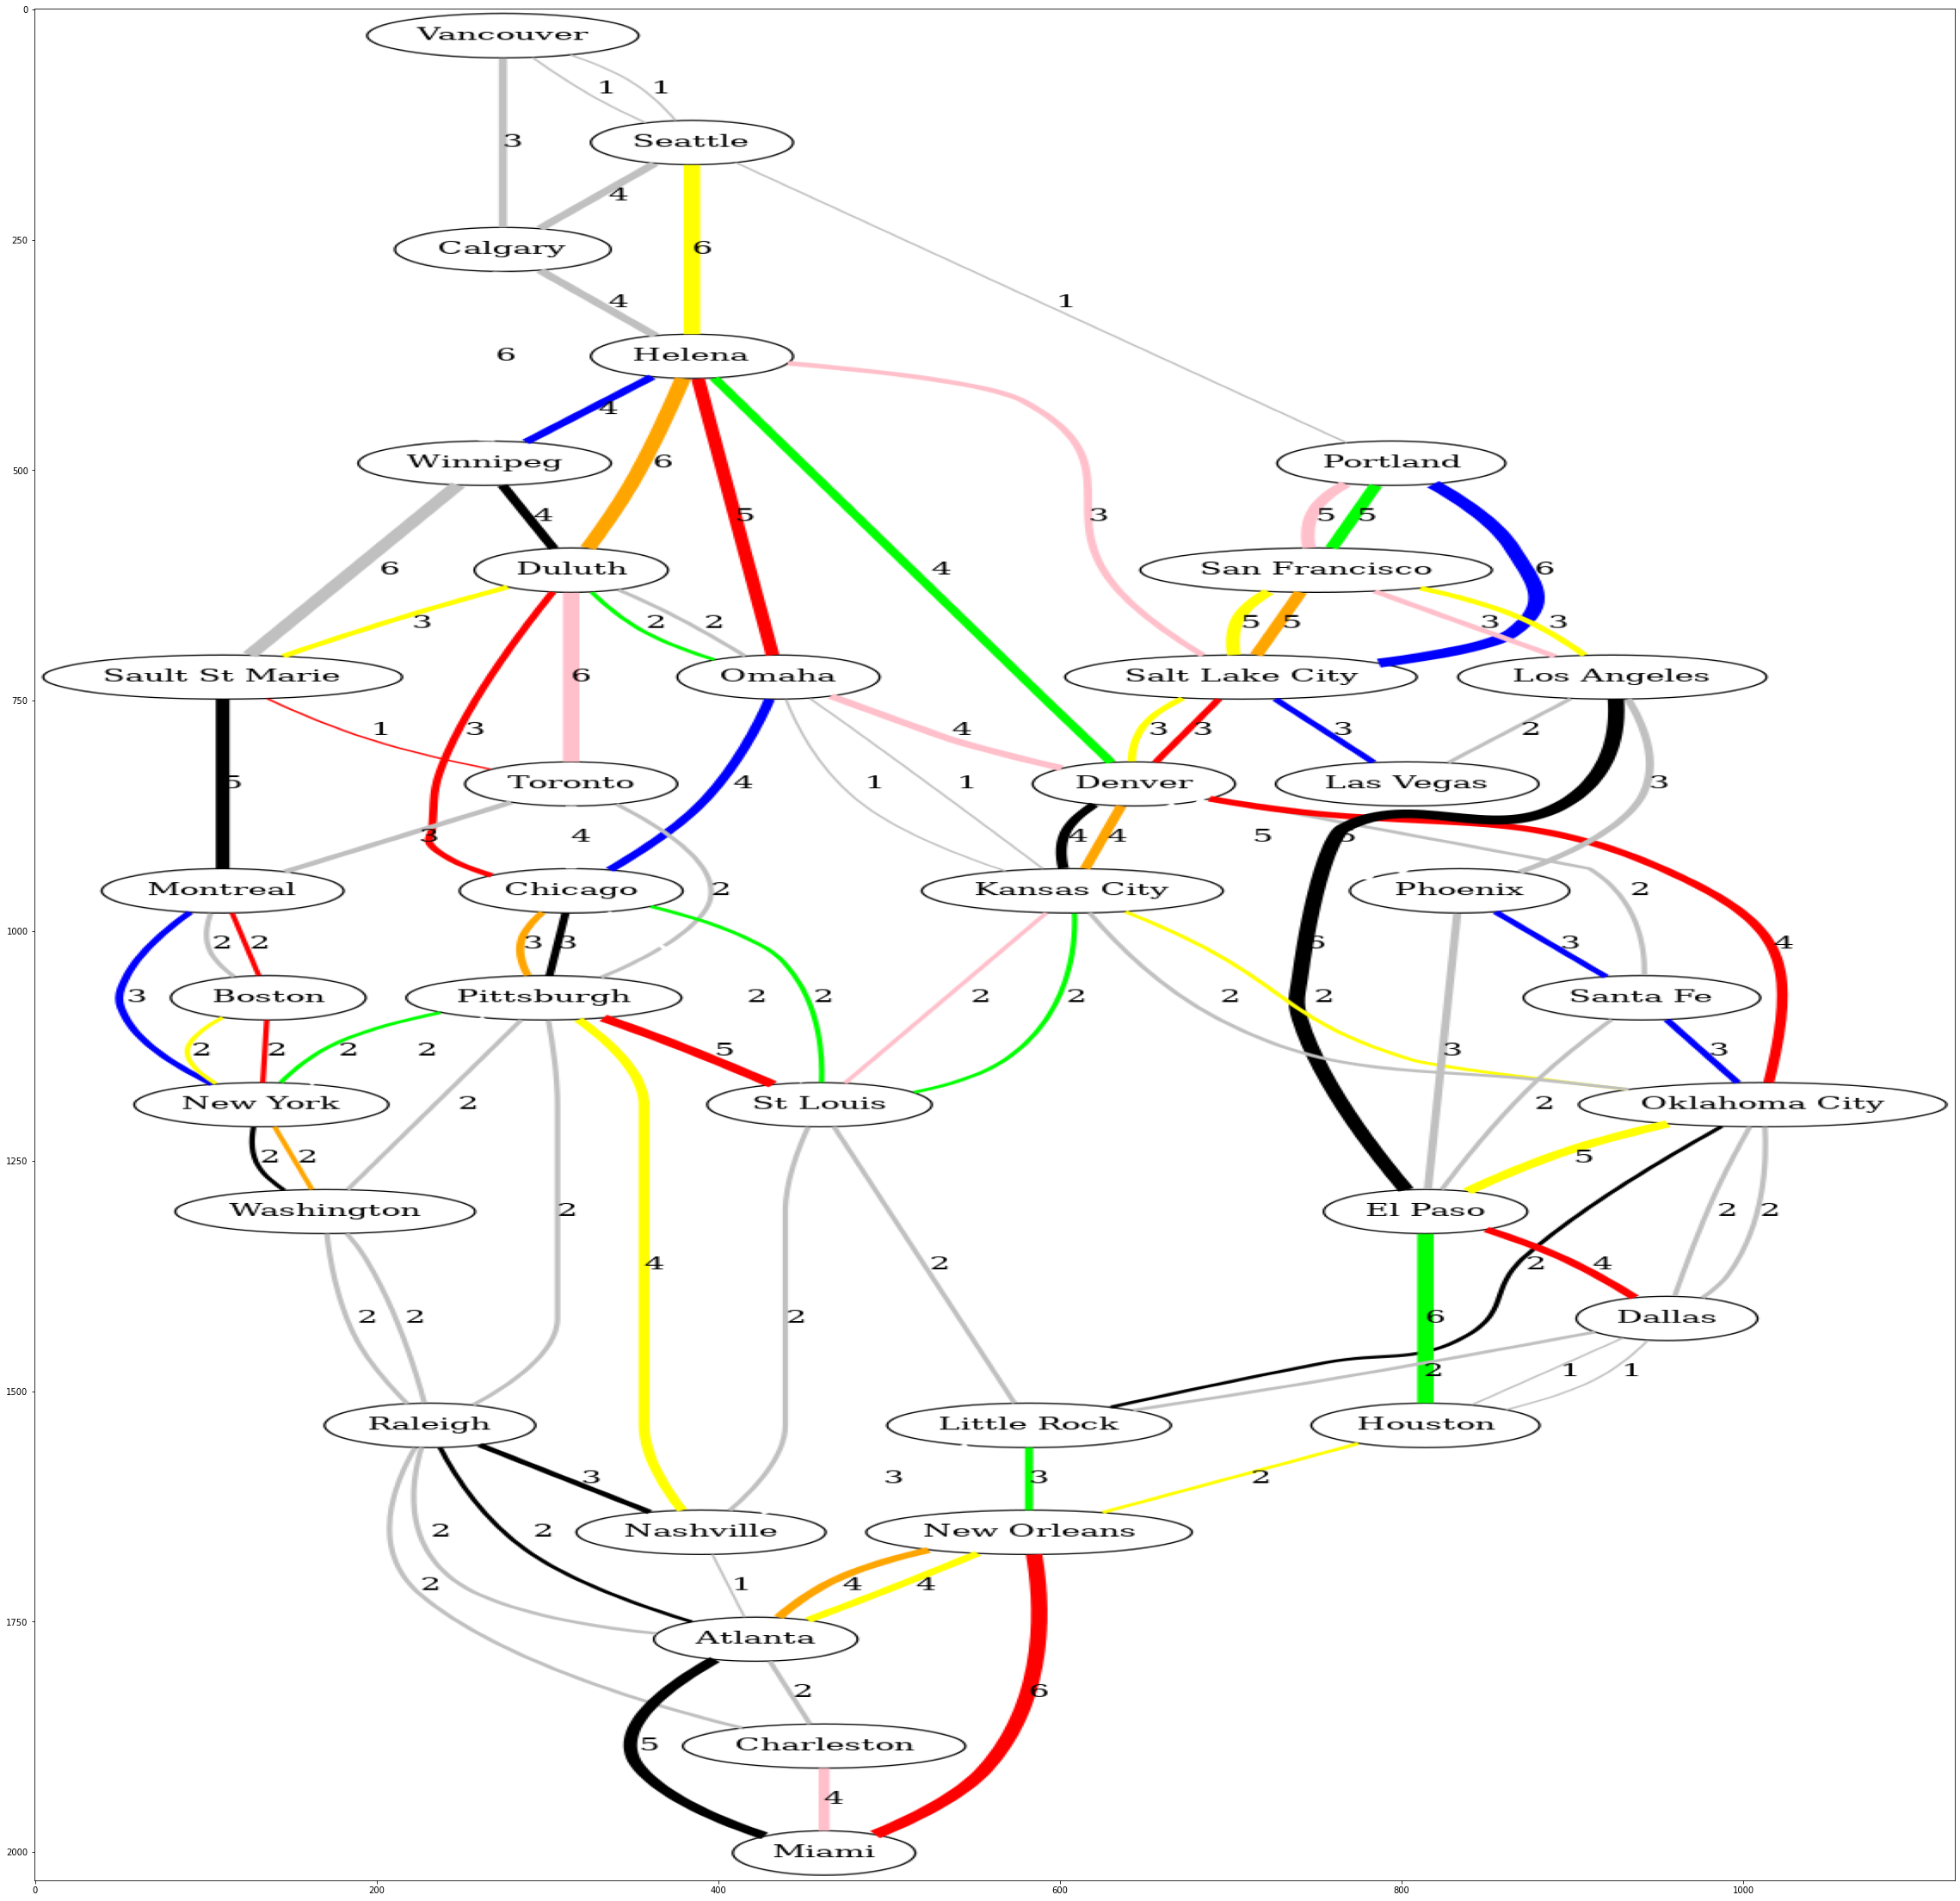

In [25]:

img = mpimg.imread(sio)
plt.figure(figsize=(40,40))
imgplot = plt.imshow(img, aspect='auto')

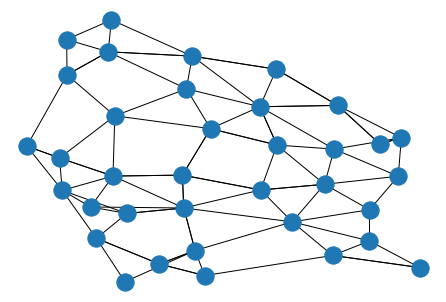

In [112]:
nx.draw(multiGraph)

In [89]:
## https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.dominating.dominating_set.html#networkx.algorithms.dominating.dominating_set
nx.algorithms.dominating_set(multiGraph)

{'Houston',
 'Las Vegas',
 'Little Rock',
 'Miami',
 'Montreal',
 'Omaha',
 'Pittsburgh',
 'San Francisco',
 'Santa Fe',
 'Vancouver',
 'Winnipeg'}

In [91]:
nx.algorithms.degree_centrality(multiGraph)

dict

In [94]:
type(nx.algorithms.all_pairs_shortest_path_length(multiGraph))

generator

In [98]:
for x in nx.algorithms.all_pairs_shortest_path_length(multiGraph): 
    print(x)

('Vancouver', {'Vancouver': 0, 'Seattle': 1, 'Calgary': 1, 'Helena': 2, 'Winnipeg': 2, 'Portland': 2, 'San Francisco': 3, 'Omaha': 3, 'Salt Lake City': 3, 'Sault St Marie': 3, 'Duluth': 3, 'Denver': 3, 'Santa Fe': 4, 'Los Angeles': 4, 'Chicago': 4, 'Kansas City': 4, 'Montreal': 4, 'Oklahoma City': 4, 'Toronto': 4, 'Las Vegas': 4, 'Phoenix': 4, 'Pittsburgh': 5, 'Boston': 5, 'St Louis': 5, 'El Paso': 5, 'Little Rock': 5, 'Dallas': 5, 'New York': 5, 'Raleigh': 6, 'Nashville': 6, 'Houston': 6, 'Washington': 6, 'New Orleans': 6, 'Atlanta': 7, 'Charleston': 7, 'Miami': 7})
('Seattle', {'Seattle': 0, 'Vancouver': 1, 'Helena': 1, 'Calgary': 1, 'Portland': 1, 'San Francisco': 2, 'Omaha': 2, 'Winnipeg': 2, 'Salt Lake City': 2, 'Duluth': 2, 'Denver': 2, 'Santa Fe': 3, 'Los Angeles': 3, 'Chicago': 3, 'Kansas City': 3, 'Oklahoma City': 3, 'Sault St Marie': 3, 'Toronto': 3, 'Las Vegas': 3, 'Phoenix': 3, 'Pittsburgh': 4, 'St Louis': 4, 'Montreal': 4, 'El Paso': 4, 'Little Rock': 4, 'Dallas': 4, 'Rale

In [101]:
nx.

NetworkXNotImplemented: not implemented for multigraph type

In [59]:
d = nx.drawing.nx_pydot.to_pydot(multiGraph) # d is a pydot graph object, dot options can be easily set
# attributes get converted from networkx,
# use set methods to control dot attributes after creation

png_str = d.create_png()
sio = BytesIO() # file-like string, appropriate for imread below
sio.write(png_str)
sio.seek(0)

img = mpimg.imread(sio)
plt.figure(figsize=(30,30))
imgplot = plt.imshow(img, aspect='auto')

NameError: name 'BytesIO' is not defined

In [124]:
df1.items

<bound method DataFrame.items of           city1  distance   color  tracks       city2
0     Vancouver         1    gray       2     Seattle
1     Vancouver         1    gray       2     Seattle
2     Vancouver         3    gray       1     Calgary
3       Seattle         1    gray       2    Portland
4       Seattle         4    gray       1     Calgary
..          ...       ...     ...     ...         ...
95  New Orleans         4  orange       2     Atlanta
96  New Orleans         6     red       1       Miami
97      Atlanta         2    gray       1  Charleston
98      Atlanta         5   black       1       Miami
99   Charleston         4    pink       1       Miami

[100 rows x 5 columns]>

In [125]:
sorted(nx.degree_centrality(multiGraph).items(), key=operator.itemgetter(1), reverse=True)[0:10]

NameError: name 'operator' is not defined